Event detection intensity curves over time and statistics, for gag accumulation events.

In [2]:
import os
import warnings
import tifffile
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
import sys
sys.path.append("..")
import obf_support

# warning suppression
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')
plt.rcParams.update({"text.usetex": False})
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

# manual plotting parameters
smooth_rolling_window = 9
t_finframe = 2  # time in s for final confocal frame preevent and the time between that frame and mfx initialization (should always be 2-5 s, depending on confocal frame size)
t_mfxtoconf = 9  # time in s between a mfx cycle end and a confocal frame start (+7s due to DM error)
mfx_size = 0.8
sum_size_um = 0.3

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
topfolders = [os.path.join(parentdir, 'exampledata\\gag\\241114'),
              os.path.join(parentdir, 'exampledata\\gag\\250117')]
eventfolders_all = []
for topfolder in topfolders:
    samplefolders = os.listdir(topfolder)
    for samplefolder in samplefolders:
        if 'confocal' not in samplefolder:
            if os.path.isdir(os.path.join(topfolder, samplefolder)):
                eventfolders = os.listdir(os.path.join(topfolder, samplefolder))
                for eventfolder in eventfolders:
                    if os.path.isdir(os.path.join(topfolder, samplefolder, eventfolder)):
                        if 'nomfx' not in eventfolder:
                            if 'manual' not in eventfolder:
                                if any(filename.endswith('.npy') for filename in os.listdir(os.path.join(topfolder, samplefolder, eventfolder))):
                                    eventfolders_all.append(os.path.join(topfolder, samplefolder, eventfolder))
print(eventfolders_all)

['c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\gag\\241114\\sample3\\e2', 'c:\\Users\\alvelidjonatan\\Documents\\GitHub\\etMINFLUX-analysis-public\\exampledata\\gag\\250117\\sample2\\e1']


c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\241114\sample3\e2
ROI0
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117\sample2\e1
ROI1
Fail in reading logfile for 250117-2-1-ROI1
ROI5
Fail in reading logfile for 250117-2-1-ROI5
1


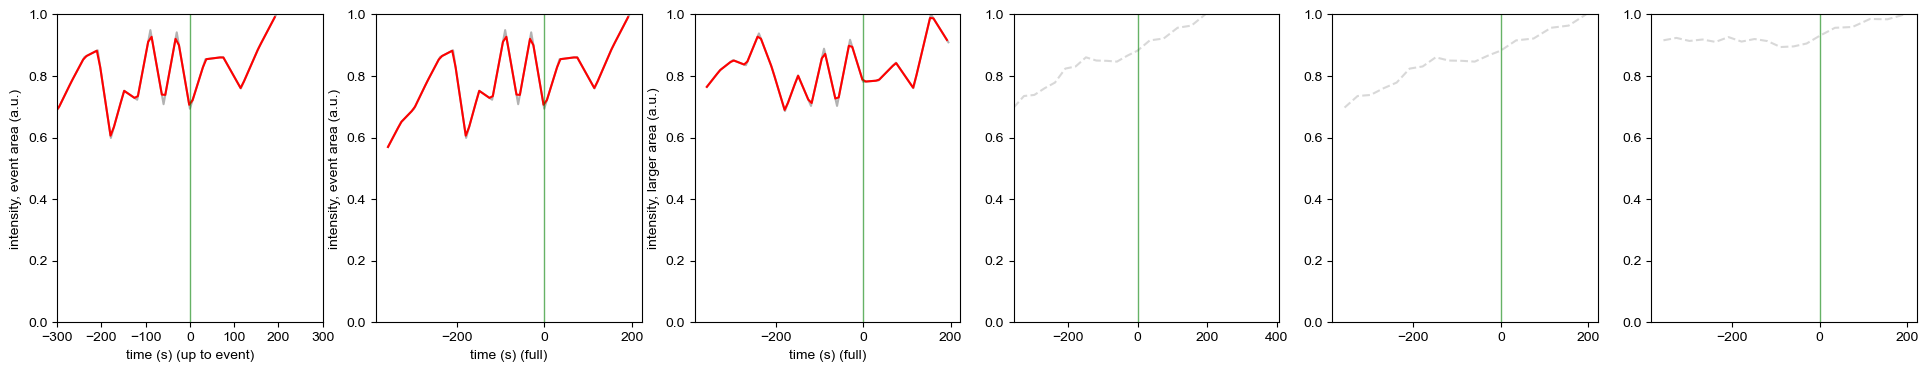

In [4]:
# PLOT ALL EVENT CURVES
%matplotlib inline

large_sums_all = []
spot_sums_all = []
t_all = []
t_eventdetect_all = []
events_cleared = []
# create figure for plotting
cols = 6
rows = 1
fig, ax = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

eventfolders = eventfolders_all
for folder in eventfolders:
    print(folder)
    filelist = os.listdir(folder)
    filelist_npy_all = [file for file in filelist if file.endswith('.npy')]
    filelist_confs = [file for file in filelist if 'conf' in file and 'analysis' not in file and '.png' not in file and 'stack' not in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]
    filelist_logs = [file for file in filelist if file.endswith('.txt')]

    # get all unique ROI names
    roinames_files = np.unique([file.split('_')[1].split('-')[0] for file in filelist_npy_all])
    N_rois = len(roinames_files)
    # get date, sample, and event from folder name
    date = folder.split('\\')[-3]
    sample = folder.split('\\')[-2].split('sample')[-1]
    event = folder.split('\\')[-1].split('e')[-1]
    # get all confocal image times
    conf_times = []
    for conffile in filelist_confs:
        conf_times.append(int(conffile.split('-')[1].split('_')[0]))
    conf_times = np.array(conf_times)
    for roiname in roinames_files:
        print(f'{roiname}')
        roiid = int(roiname.split('ROI')[-1])
        filelist_npy = [file for file in filelist_npy_all if roiname+'-' in file]
        N_t = len(filelist_npy)
        # load msr file to read confocal image settings
        # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
        file_msr = os.path.join(folder, filelist_msr[0])
        msr_dataset = obf_support.File(file_msr)
        conf_msr_stack_index = 0
        conf_stack = msr_dataset.stacks[conf_msr_stack_index]
        conf_img_last = [np.reshape(conf_stack.data, (conf_stack.shape[0], conf_stack.shape[1])).T]  # read last confocal image from msr file
        pxsize = conf_stack.pixel_sizes[0]*1e6
        pxshift = pxsize/2
        conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
        conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
        conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)
        # get roi pos
        roi_pos = (int(filelist_npy[0].split('[')[1].split(',')[0]),int(filelist_npy[0].split(']')[0].split(',')[1]))
        roi_pos_um = (roi_pos[0]*pxsize+conf_offset[0], roi_pos[1]*pxsize+conf_offset[1])

        # set other parameters for the plotting
        N_rois = len(filelist_msr)
        plt_roi_size = int(np.ceil(0.8/pxsize))
        sum_size = int(np.ceil(sum_size_um/pxsize))
        large_sum_size = int(np.ceil(mfx_size*1.2/2/pxsize))

        # get all confocal images in one stack
        images_conf = []
        for conf_file in filelist_confs:
            images_conf.append(tifffile.imread(os.path.join(folder, conf_file)))
        frames_preevent = len(images_conf[0])
        images_conf = np.concatenate(images_conf)
        images_conf = np.concatenate([images_conf, conf_img_last])

        # read timing info from log file
        file_log = os.path.join(folder, filelist_logs[0])
        log_dict = {}
        with open(file_log) as f:
            for line in f:
                key, sep, value = line.strip().partition(": ")
                log_dict[key] = value
        t_mfxcycs = []
        try:
            if date in ['241016', '241105', '241114', '241115', '241212']:
                try:
                    t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate-cycle0'], '%Hh%Mm%Ss%fus')
                    t_mfxcyc0 = datetime.datetime.strptime(log_dict['mfx_end-cycle0'], '%Hh%Mm%Ss%fus')
                    try:
                        t_mfxcyc1 = datetime.datetime.strptime(log_dict['mfx_end-cycle1'], '%Hh%Mm%Ss%fus')
                    except:
                        t_mfxcyc1 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
                    t_sec_mfx = (t_mfxcyc1-t_mfxcyc0).seconds  # time between confocal frames during MFX
                except:
                    try:
                        t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate-cycle0'], '%Hh%Mm%Ss%fus')
                    except:
                        t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate'], '%Hh%Mm%Ss%fus')
                    t_mfxcyc0 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
                    t_sec_mfx = (t_mfxcyc0-t_confevent_end).seconds  # time between confocal frames during MFX
            else:
                try:
                    t_confevent_end = datetime.datetime.strptime(log_dict[f'mfx_initiate-id{roiid}-cycle0'], '%Hh%Mm%Ss%fus')
                    t_mfxcyc0 = datetime.datetime.strptime(log_dict[f'mfx_end-id{roiid}-cycle0'], '%Hh%Mm%Ss%fus')
                    try:
                        t_mfxcyc1 = datetime.datetime.strptime(log_dict[f'mfx_end-id{roiid}-cycle1'], '%Hh%Mm%Ss%fus')
                    except:
                        t_mfxcyc1 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
                    t_sec_mfx = (t_mfxcyc1-t_mfxcyc0).seconds  # time between confocal frames during MFX
                except:
                    try:
                        t_confevent_end = datetime.datetime.strptime(log_dict[f'mfx_initiate-id{roiid}-cycle0'], '%Hh%Mm%Ss%fus')
                    except:
                        t_confevent_end = datetime.datetime.strptime(log_dict['mfx_initiate'], '%Hh%Mm%Ss%fus')
                    t_mfxcyc0 = datetime.datetime.strptime(log_dict['mfx_end'], '%Hh%Mm%Ss%fus')
                    t_sec_mfx = (t_mfxcyc0-t_confevent_end).seconds  # time between confocal frames during MFX
            try:
                t_conf0_start = datetime.datetime.strptime(log_dict['experiment_start'], '%Hh%Mm%Ss%fus')
            except:
                t_conf0_start = datetime.datetime.strptime('12h00m00s000000us', '%Hh%Mm%Ss%fus')
            t_sec_frames_preevent = (t_confevent_end-t_conf0_start).seconds  # time between confocal frames before MFX
            t_sec_mfx0 = (t_mfxcyc0-t_confevent_end).seconds  # time for one MFX rec
            
            # get t array for all confocal frames
            t = np.linspace(0, t_sec_frames_preevent-t_finframe, frames_preevent)
            t_eventdetect = t[-1]
            t = np.append(t, t[-1]+t_sec_mfx0+t_mfxtoconf)
            for _ in range(len(filelist_confs)-2+1):
                t = np.append(t,t[-1]+t_sec_mfx+t_mfxtoconf)

            # get intensity limits for confocal images
            conf_zoom_lim = (np.min(images_conf[:,roi_pos[1]-sum_size:roi_pos[1]+sum_size, roi_pos[0]-sum_size:roi_pos[0]+sum_size]), np.max(images_conf[:,roi_pos[1]-sum_size:roi_pos[1]+sum_size, roi_pos[0]-sum_size:roi_pos[0]+sum_size]))
            # get x,y lims for confocal image zooms
            lims_confimg = np.array([roi_pos_um[0], roi_pos_um[0], roi_pos_um[1], roi_pos_um[1]]) + np.array([-plt_roi_size, plt_roi_size, -plt_roi_size, plt_roi_size])*pxsize
            # plot image zooms and plots of intensity over time
            spot_sums = []
            large_sums = []
            for conf_idx_p in range(len(images_conf)):
                conf_idx = len(images_conf)-conf_idx_p-1
                plotrow = conf_idx//cols+1
                plotcol = conf_idx%cols
                conf_img = images_conf[conf_idx_p]
                spot_sums.append(np.sum(np.sum(conf_img[roi_pos[1]-sum_size:roi_pos[1]+sum_size+1, roi_pos[0]-sum_size:roi_pos[0]+sum_size+1]))/sum_size**2)
                large_sums.append(np.sum(np.sum(conf_img[roi_pos[1]-large_sum_size:roi_pos[1]+large_sum_size+1, roi_pos[0]-large_sum_size:roi_pos[0]+large_sum_size+1]))/large_sum_size**2)
            if len(t) > len(spot_sums):
                t = t[:-1]
            spot_sums_sm = uniform_filter1d(spot_sums, size=smooth_rolling_window, mode='nearest')
            large_sums_sm = uniform_filter1d(large_sums, size=smooth_rolling_window, mode='nearest')
            t_max = t[np.argmax(spot_sums_sm)]
            if np.min(t-t_max) > -3000:
                t_all.append(t-t_eventdetect)
                spot_sums_all.append(spot_sums)
                large_sums_all.append(large_sums)
                t_eventdetect_all.append(0)
                events_cleared.append(folder)
        except:
            print(f'Fail in reading logfile for {date}-{sample}-{event}-{roiname}')

print(len(spot_sums_all))

t_lim_max = 0
t_lim_min = 0
y_lim_max_spot = 0
y_lim_max_large = 0
for t, spot_sums, large_sums in zip(t_all, spot_sums_all, large_sums_all):
    #t = t-t_eventdetect
    spot_sums_sm = uniform_filter1d(spot_sums, size=smooth_rolling_window, mode='nearest')
    large_sums_sm = uniform_filter1d(large_sums, size=smooth_rolling_window, mode='nearest')
    ax[0].plot(t, spot_sums/(np.max(spot_sums)), '-', color='k', alpha=0.3)
    ax[3].plot(t, spot_sums_sm/(np.max(spot_sums_sm)), '--', color='gray', alpha=0.3)
    ax[1].plot(t, spot_sums/(np.max(spot_sums)), '-', color='k', alpha=0.3)
    ax[4].plot(t, spot_sums_sm/(np.max(spot_sums_sm)), '--', color='gray', alpha=0.3)
    ax[2].plot(t, large_sums/(np.max(large_sums)), '-', color='k', alpha=0.3)
    ax[5].plot(t, large_sums_sm/(np.max(large_sums_sm)), '--', color='gray', alpha=0.3)
    if t_eventdetect+t_eventdetect/7 > t_lim_max:
        t_lim_max = t_eventdetect+t_eventdetect/7
    if t_eventdetect > t_lim_min:
        t_lim_min = t_eventdetect
    
X_fit = np.linspace(-t_lim_min, t_lim_max, 100)

y_all = [ls/np.max(ls) for ls in spot_sums_all]
yintp_all_spotsums = []
for t, y in zip(t_all, y_all):
    yintp = np.interp(X_fit, t, y)
    yintp[(X_fit<np.min(t))] = np.nan
    yintp[(X_fit>np.max(t))] = np.nan
    yintp_all_spotsums.append(yintp)
ax[0].plot(X_fit, np.nanmean(yintp_all_spotsums, axis=0), 'r')
ax[1].plot(X_fit, np.nanmean(yintp_all_spotsums, axis=0), 'r')
y_all = [ls/np.max(ls) for ls in large_sums_all]
yintp_all_largesums = []
for t, y in zip(t_all, y_all):
    yintp = np.interp(X_fit, t, y)
    yintp[(X_fit<np.min(t))] = np.nan
    yintp[(X_fit>np.max(t))] = np.nan
    yintp_all_largesums.append(yintp)
ax[2].plot(X_fit, np.nanmean(yintp_all_largesums, axis=0), 'r')

ax[0].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[1].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[2].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[3].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[4].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[5].axvline(x=0, linewidth=1, color='g', alpha=0.6)
ax[0].set_ylim([0, 1])
ax[3].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
ax[4].set_ylim([0, 1])
ax[2].set_ylim([0, 1])
ax[5].set_ylim([0, 1])
ax[0].set_xlim([-300, 300])
ax[3].set_xlim([-t_lim_min, t_lim_max])
ax[0].set_xlabel('time (s) (up to event)')
ax[0].set_ylabel('intensity, event area (a.u.)')
ax[1].set_xlabel('time (s) (full)')
ax[1].set_ylabel('intensity, event area (a.u.)')
ax[2].set_xlabel('time (s) (full)')
ax[2].set_ylabel('intensity, larger area (a.u.)')

plt.show()

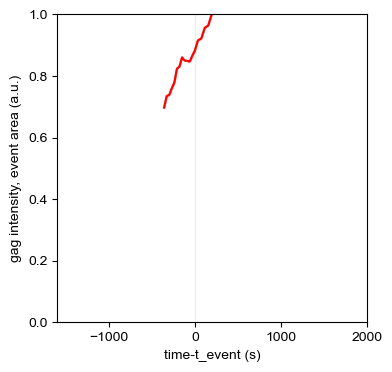

In [14]:
# PLOT ALL EVENT CURVES WITH MEAN AND STANDARD DEVIATION
t_lim_max = 0
t_lim_min = 0
y_lim_max_spot = 0
y_lim_max_large = 0
spot_sums_sm_all = []
fig = plt.figure(figsize=(4,4))
for t, spot_sums, large_sums in zip(t_all, spot_sums_all, large_sums_all):
    spot_sums_sm = uniform_filter1d(spot_sums, size=smooth_rolling_window, mode='nearest')
    large_sums_sm = uniform_filter1d(large_sums, size=smooth_rolling_window, mode='nearest')
    plt.plot(t, spot_sums_sm/(np.max(spot_sums_sm)), '-', color='gray', alpha=0.5)
    if t_eventdetect+t_eventdetect/7 > t_lim_max:
        t_lim_max = t_eventdetect+t_eventdetect/7
    if t_eventdetect > t_lim_min:
        t_lim_min = t_eventdetect
    spot_sums_sm_all.append(spot_sums_sm)
    
X_fit = np.linspace(-t_lim_min, t_lim_max, 100)
y_all = [ls/np.max(ls) for ls in spot_sums_sm_all]
yintp_all_spotsums = []
for t, y in zip(t_all, y_all):
    yintp = np.interp(X_fit, t, y)
    yintp[(X_fit<np.min(t))] = np.nan
    yintp[(X_fit>np.max(t))] = np.nan
    yintp_all_spotsums.append(yintp)
plt.plot(X_fit, np.nanmean(yintp_all_spotsums, axis=0), 'r')
plt.fill_between(X_fit, np.nanmean(yintp_all_spotsums, axis=0)-np.nanstd(yintp_all_spotsums, axis=0), np.nanmean(yintp_all_spotsums, axis=0)+np.nanstd(yintp_all_spotsums, axis=0), color='r', alpha=0.3)

for t in t_eventdetect_all:
    plt.axvline(x=t, linewidth=1, color='g', alpha=0.1)
plt.ylim([0, 1])
plt.xlim([-1600, 2000])
plt.xlabel(f'time-t_event (s)')
plt.ylabel('gag intensity, event area (a.u.)')

plt.show()

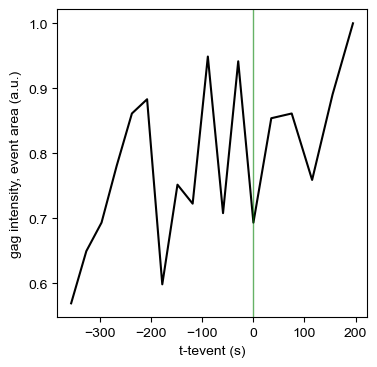

In [11]:
# PLOT SINGLE EVENT CURVE
roiidx = 0

y_all = [ls/np.max(ls) for ls in spot_sums_all]
fig = plt.figure(figsize=(4,4))
for t,y,t_event in zip(t_all[roiidx:roiidx+1], y_all[roiidx:roiidx+1], t_eventdetect_all[roiidx:roiidx+1]):
    plt.plot(t, y, 'k')
    plt.axvline(x=t_event, linewidth=1, color='g', alpha=0.6)

#plt.ylim([0, 1.0])
#plt.xlim([-600, 1200])
plt.xlabel('t-tevent (s)')
plt.ylabel('gag intensity, event area (a.u.)')

plt.show()

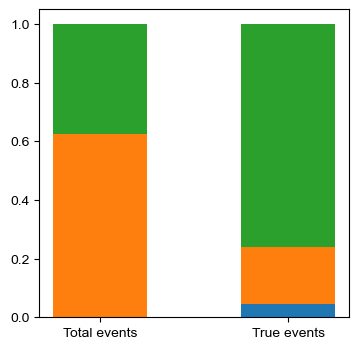

In [12]:
### EVENT STATISTICS
tot_events = 107
valid_events = 67
valid_events_overlapping_bulge = 13
valid_events_overlapping_budding = 3

cat = ("Total events", "True events")
counts = {"True2": np.array([0, valid_events_overlapping_budding/valid_events]), "True": np.array([valid_events/tot_events, valid_events_overlapping_bulge/valid_events]), "False": np.array([(tot_events-valid_events)/tot_events, (valid_events-valid_events_overlapping_bulge-valid_events_overlapping_budding)/valid_events])}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2)
for boolean, count in counts.items():
    p = ax.bar(cat, count, width, label=boolean, bottom=bottom)
    bottom += count
fig.set_size_inches(4, 4)
plt.show()